# Modello di Poisson {#sec-poisson-model}

**Prerequisiti**

**Concetti e competenze chiave**

- Comprendere la distribuzione di Poisson come un modello probabilistico adatto per descrivere eventi rari in un intervallo di tempo o spazio fisso.
- Sapere applicare il metodo basato su griglia per derivare la distribuzione a posteriori del parametro λ della distribuzione di Poisson.
- Conoscere il modello coniugato Gamma-Poisson, dimostrando come la distribuzione a priori Gamma si combini con la verosimiglianza di Poisson per produrre una distribuzione a posteriori Gamma.
- Sapere come calcolare e interpretare le probabilità utilizzando la distribuzione a posteriori.

**Preparazione del Notebook**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore")

In [4]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "poisson-model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina"

## Introduzione

Un tema di particolare importanza emerge quando ci occupiamo di variabili di risposta che rappresentano conteggi, indicate con $y$. Queste variabili possono assumere valori discreti come 0, 1, 2, ecc., e trovano applicazione in numerosi ambiti della psicologia. In particolare, sono fondamentali nei modelli che indagano l'incidenza di eventi psicologici specifici, come la quantificazione della frequenza con cui si manifestano i sintomi di un disturbo in determinati intervalli di tempo.

In questo capitolo, ci concentreremo sulla stima del tasso medio di incidenza degli eventi all'interno di un determinato sistema, cioè sul numero medio di eventi che si verificano per unità di tempo o spazio. A tal fine, analizzeremo la stima del parametro $\mu_i$, comunemente noto come "rate", utilizzando il modello di Poisson.

Esamineremo la derivazione della distribuzione a posteriori attraverso il metodo basato su griglia, impiegando una funzione di verosimiglianza di Poisson e una distribuzione a priori Gamma. Inoltre, dimostreremo l'equivalenza tra la soluzione ottenuta analiticamente e quella ricavata tramite simulazione.

## Distribuzione di Poisson

La distribuzione di Poisson è un modello probabilistico utilizzato per descrivere il numero di eventi che si verificano in un intervallo di tempo o spazio fisso, partendo dall'assunto che tali eventi si verifichino con una frequenza media costante e in modo indipendente rispetto al tempo trascorso dall'ultimo evento. Se un dato $y$ segue una distribuzione di Poisson con parametro $\lambda$, allora la probabilità di osservare un singolo valore $y_i$ è data da:

$$
f(y_i | \lambda) = \frac{e^{-\lambda} \lambda^{y_i}}{y_i!},
$$

dove $\lambda > 0$ rappresenta la frequenza media di occorrenza degli eventi, e $y_i$ è il numero di eventi osservati. La distribuzione di Poisson ha la caratteristica che sia il valore atteso che la varianza di una variabile casuale $Y$ che segue questa distribuzione sono pari a $\lambda$, cioè $E(Y) = \lambda$ e $\text{Var}(Y) = \lambda$.

### Esempio di Simulazione

Per illustrare l'applicazione pratica della distribuzione di Poisson, consideriamo un caso in cui il parametro della distribuzione è $\lambda = 2$. Questo scenario può rappresentare, ad esempio, il numero di compulsioni eseguite da un paziente con disturbo ossessivo-compulsivo in un determinato intervallo di tempo, supponendo che questi eventi si verifichino con una frequenza media di 2 all'ora. In altre parole, con $\lambda = 2$, ci aspettiamo in media 2 eventi (compulsioni) per ora.

La probabilità di osservare esattamente $k$ eventi in un'ora è calcolata dalla formula:

$$
f(k | \lambda) = \frac{e^{-\lambda} \lambda^k}{k!}
$$

Nel caso specifico con $\lambda = 2$, le probabilità per i primi valori di $k$ sono:

- La probabilità di osservare 0 eventi in un'ora è $\frac{e^{-2} \cdot 2^0}{0!} = e^{-2} \approx 0{.}1353$.
- La probabilità di osservare 1 evento in un'ora è $\frac{e^{-2} \cdot 2^1}{1!} = 2e^{-2} \approx 0{.}2707$.
- La probabilità di osservare 2 eventi in un'ora è $\frac{e^{-2} \cdot 2^2}{2!} = 2e^{-2} \approx 0{.}2707$.
- E così via per $k = 3$, $k = 4$, e così via.

Questo esempio illustra come la distribuzione di Poisson possa essere utilizzata per modellare il numero di eventi rari che si verificano in un intervallo temporale fisso, con una frequenza media nota.

Svolgiamo i calcoli usando la funzione `poisson` del modulo `scipy.stats`:

In [5]:
lam_true = 2
# Creazione di un array di valori da 0 a 9
k_values = np.arange(0, 10)  

# Calcolo delle probabilità per ogni valore in k_values
probabilities = stats.poisson.pmf(k_values, lam_true)

for k, prob in zip(k_values, probabilities):
    print(f"Probabilità di {k} eventi: {prob:.4f}")

Probabilità di 0 eventi: 0.1353
Probabilità di 1 eventi: 0.2707
Probabilità di 2 eventi: 0.2707
Probabilità di 3 eventi: 0.1804
Probabilità di 4 eventi: 0.0902
Probabilità di 5 eventi: 0.0361
Probabilità di 6 eventi: 0.0120
Probabilità di 7 eventi: 0.0034
Probabilità di 8 eventi: 0.0009
Probabilità di 9 eventi: 0.0002


Per un vettore $y = (y_1, \dots, y_n)$ di osservazioni indipendenti e identicamente distribuite, la verosimiglianza diventa:

$$
f(y|\lambda)=\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
=\frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^{n}y_i!}.
$$

### Distribuzione Gamma

Prima di affrontare il modello coniugato gamma-poisson, è utile rivedere brevemente la distribuzione Gamma—consultare la sezione @sec-cont-rv-distr per maggiori dettagli. La funzione di densità della distribuzione Gamma è definita come:

$$ f(x | \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x}, $$

dove:

- $\alpha$ determina la forma generale della curva di distribuzione. Con un valore basso di $\alpha$, la distribuzione è fortemente inclinata verso valori bassi di $x$ con una lunga coda che si estende verso valori più alti. Man mano che $\alpha$ aumenta, la curva si sposta verso destra e diventa più simmetrica.
- $\beta$ controlla quanto ampiamente i valori di $x$ sono distribuiti lungo l'asse orizzontale. Un alto valore di $\beta$ comporta una distribuzione che decresce rapidamente, indicando una maggiore concentrazione di massa vicino all'origine.

È importante notare che `Scipy` utilizza una parametrizzazione leggermente diversa della distribuzione Gamma:

- *Parametro di forma*: equivalente a $\alpha$ come discusso sopra;
- *Parametro di scala*: indicato come `scale`, che corrisponde al reciproco del parametro $\beta$ nella formula precedente.

Pertanto, per calcolare la densità di probabilità in `scipy.stats`, utilizzeremo:

```python
stats.gamma.pdf(x, a=alpha, scale=1/beta)
```

## Metodo Basato su Griglia

Supponiamo di avere osservato i seguenti dati.

In [49]:
y = np.array([2, 1, 3, 2, 2, 1, 1, 1])

Per questi dati, imponiamo una distribuzione Gamma quale distribuzione a priori per il parametro $\lambda$ della distribuzione di Poisson.

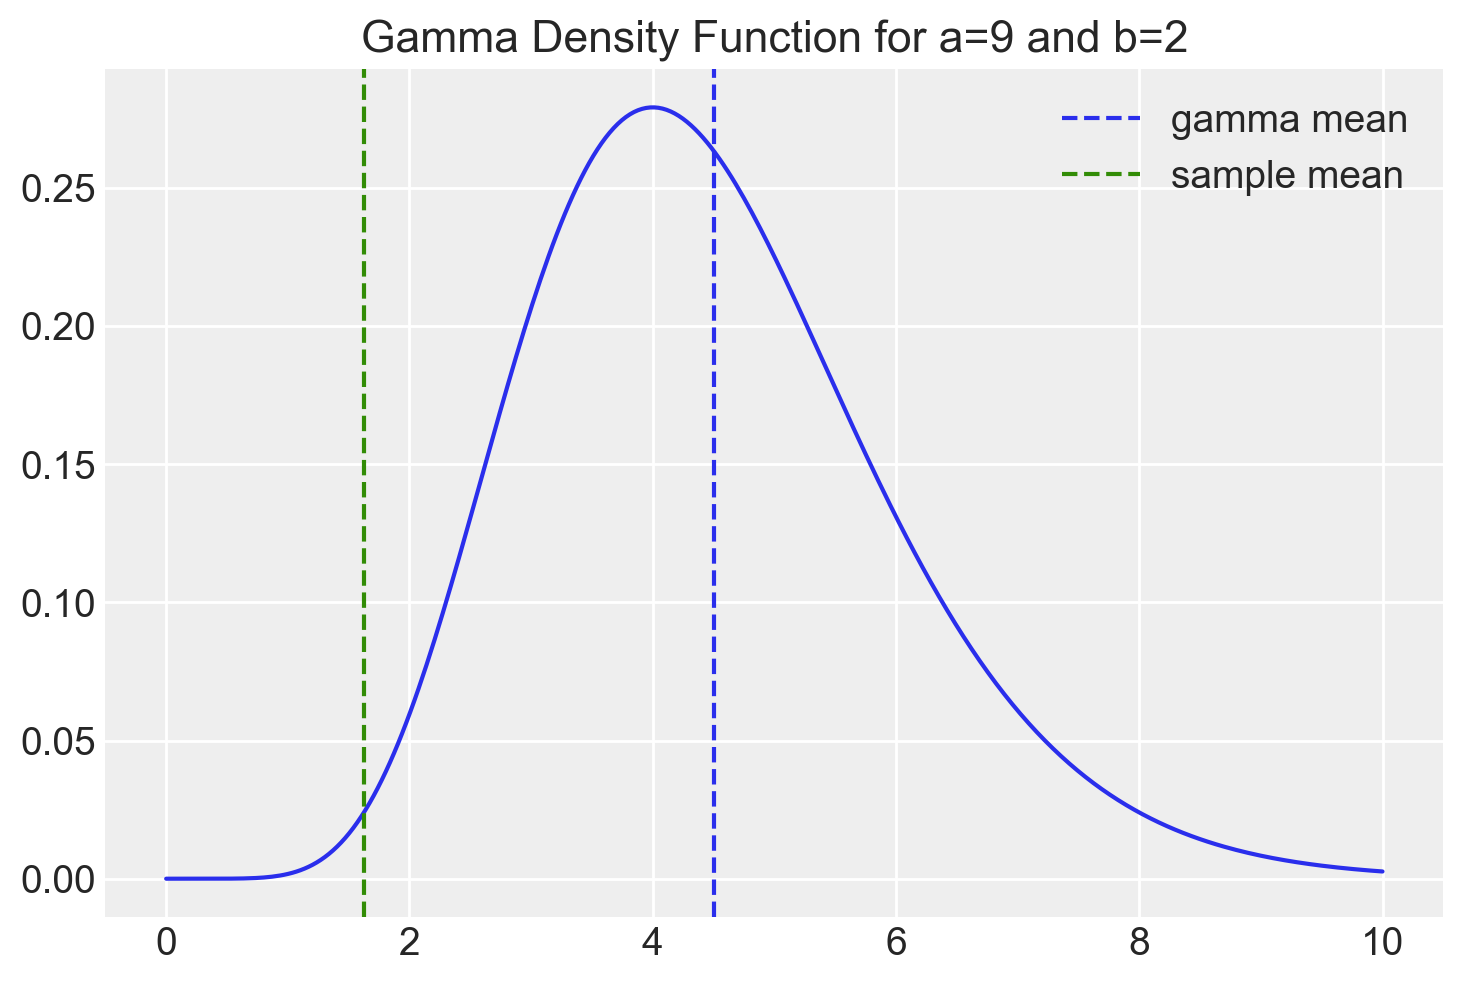

In [39]:
alpha_prior = 9
beta_prior = 2

x = np.linspace(start=0, stop=10, num=300)

plt.plot(x, stats.gamma.pdf(x, a=alpha_prior, scale=1 / beta_prior))
plt.axvline(x=alpha_prior / beta_prior, linestyle="--", label="gamma mean")
plt.axvline(x=y.mean(), linestyle="--", color="C2", label="sample mean")
plt.legend()
plt.title(f"Gamma Density Function for a={9} and b={2}")
plt.show()

Poniamoci l'obiettivo di usare il metodo basato su griglia per derivare la distribuzione a posteriori per il parametro $\lambda$ della distribuzione di Poisson. Iniziamo con la creazione della griglia per  $\lambda$ nell'intervallo [0.01, 10].

In [40]:
# Evita zero per evitare divisione per zero
lambda_grid = np.linspace(0.01, 10, 1000)
  
len(lambda_grid)

1000

Calcoliamo la distribuzione a priori.

In [61]:
prior = stats.gamma.pdf(lambda_grid, a=alpha_prior, scale=1 / beta_prior)

len(prior)

1000

Calcoliamo la verosimiglianza per ciascun valore di lambda.

In [62]:
likelihood = np.ones_like(lambda_grid)
for yi in y:
    likelihood *= stats.poisson.pmf(yi, lambda_grid)
    
len(likelihood)

1000

Calcoliamo la distribuzione a posteriori non normalizzata.

In [63]:
posterior_unnormalized = likelihood * prior

Normalizziamo la distribuzione a posteriori.

In [64]:
posterior = posterior_unnormalized / np.sum(
    posterior_unnormalized * (lambda_grid[1] - lambda_grid[0])
)

len(posterior)

1000

Visualizzazione dei risultati.

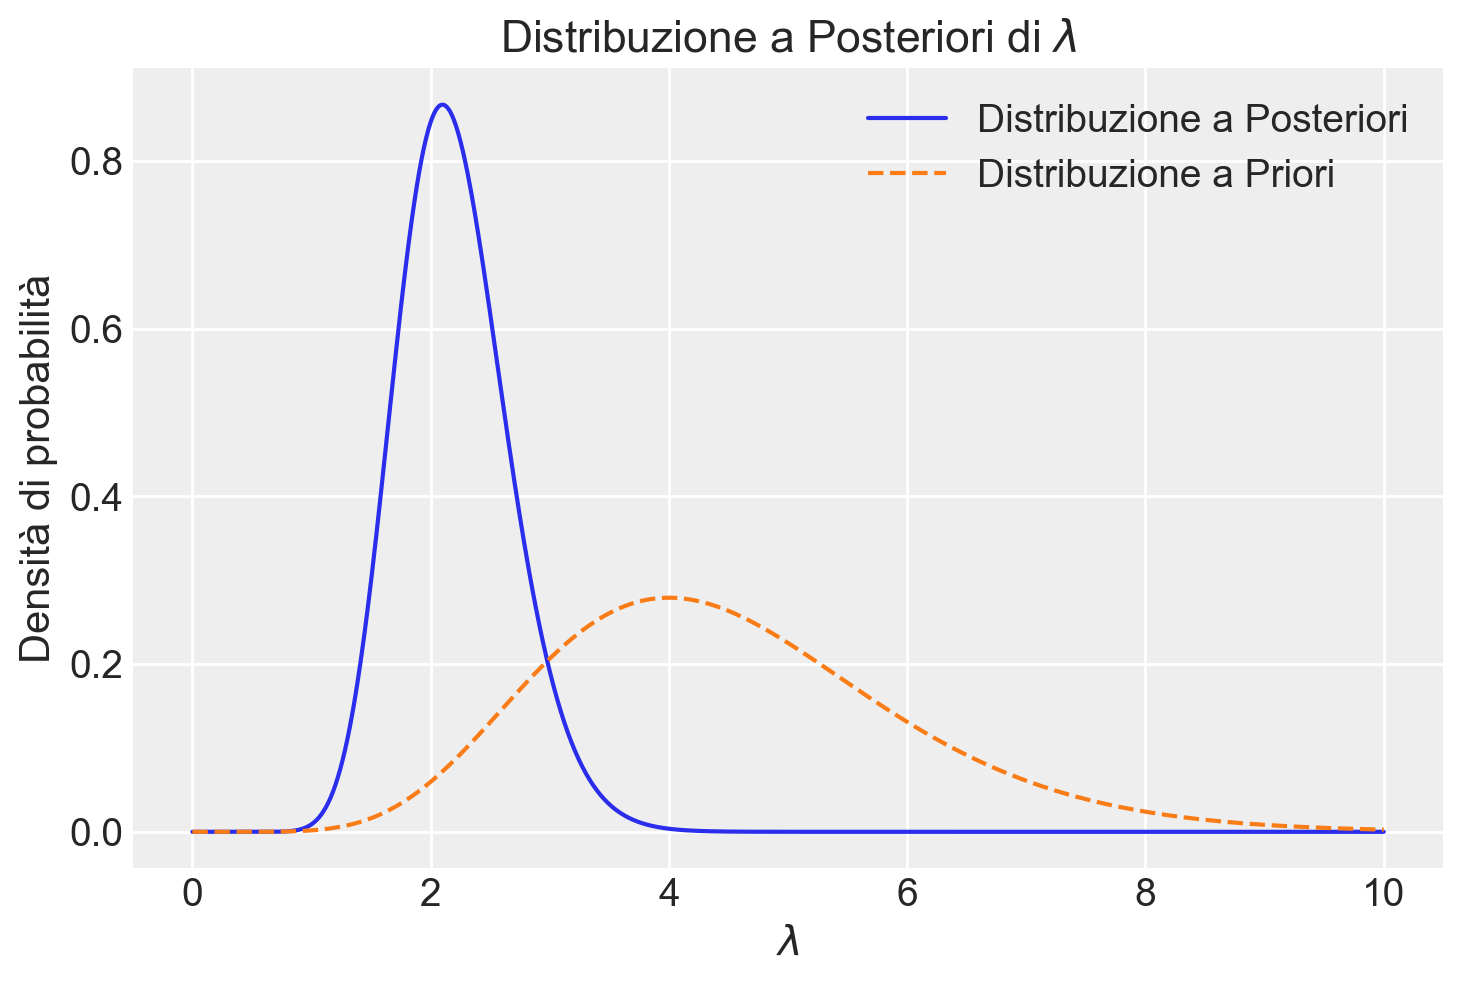

In [65]:
plt.plot(lambda_grid, posterior, label="Distribuzione a Posteriori")
plt.plot(lambda_grid, prior, "--", label="Distribuzione a Priori")
plt.xlabel(r"$\lambda$")
plt.ylabel("Densità di probabilità")
plt.legend()
plt.title("Distribuzione a Posteriori di $\lambda$")
plt.show()

## Modello Coniugato Gamma-Poission

Per calcolare analiticamente la distribuzione a posteriori nel contesto di un modello gamma-Poisson possiamo seguire un processo diretto. Il modello Gamma-Poisson è coniugato, il che significa che la distribuzione a posteriori sarà ancora una distribuzione Gamma. 

Partiamo dal teorema di Bayes:

   $f(\lambda \mid y) \propto f(y \mid \lambda) \cdot f(\lambda) ,$

dove $f(\lambda \mid y)$ è la distribuzione a posteriori, $f(y \mid \lambda)$ è la verosimiglianza, e $f(\lambda)$ è la distribuzione a priori.

Definiamo la verosimiglianza (distribuzione di Poisson):

   $f(y \mid \lambda) = \prod_{i=1}^n \frac{e^{-\lambda}\lambda^{y_i}}{y_i!} = \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^n y_i!}.$

Definiamo la distribuzione a priori (distribuzione Gamma):

   $f(\lambda) = \frac{b^a}{\Gamma(a)}\lambda^{a-1}e^{-b\lambda}.$

Ora, moltiplichiamo la verosimiglianza per la distribuzione a priori:

   $f(\lambda|y) \propto \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^n y_i!} \cdot \frac{b^a}{\Gamma(a)}\lambda^{a-1}e^{-b\lambda}.$

Semplifichiamo, eliminando i termini costanti (che non dipendono da $\lambda$):

   $f(\lambda \mid y) \propto e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i} \cdot \lambda^{a-1}e^{-b\lambda}.$

Raggruppiamo i termini:

   $f(\lambda|y) \propto \lambda^{\sum_{i=1}^n y_i} \cdot \lambda^{a-1} \cdot e^{-n\lambda} \cdot e^{-b\lambda}.$

Semplifichiamo ulteriormente:

   $f(\lambda \mid y) \propto \lambda^{\sum_{i=1}^n y_i + a - 1} \cdot e^{-(n+b)\lambda}.$

Riconosciamo che questa è la forma di una distribuzione Gamma con nuovi parametri:

   $f(\lambda \mid y) \propto \lambda^{(\sum_{i=1}^n y_i + a) - 1} \cdot e^{-(n+b)\lambda}.$

Quindi, la distribuzione a posteriori è una Gamma con parametri:

- $\alpha_{post} = a + \sum_{i=1}^n y_i$,
- $\beta_{post} = b + n$,

dove:

- $a$ e $b$ sono i parametri della distribuzione Gamma a priori,
- $\sum_{i=1}^n y_i$ è la somma di tutte le osservazioni,
- $n$ è il numero di osservazioni.

Questa derivazione mostra come la distribuzione a posteriori mantiene la forma di una Gamma, ma con parametri aggiornati che incorporano l'informazione dai dati osservati.

Utilizzando i parametri aggiornati, rappresentiamo graficamente la distribuzione a posteriori.

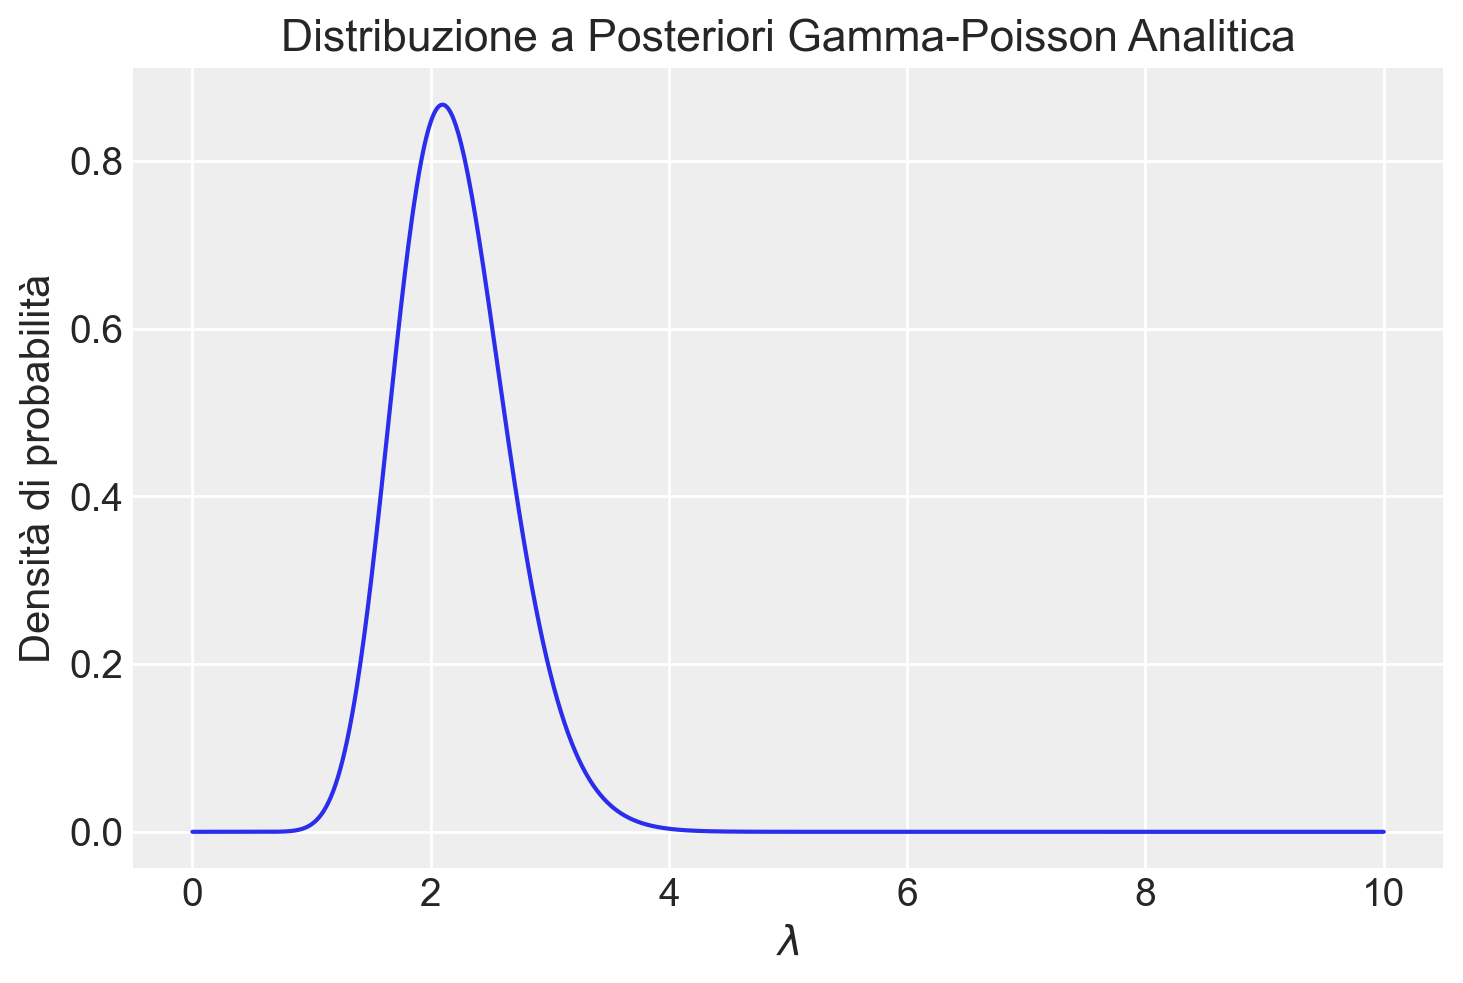

In [68]:
# Aggiornamento dei parametri per la distribuzione a posteriori
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + len(y)

# Calcolo della distribuzione a posteriori analitica sulla griglia
posterior_analytic = stats.gamma.pdf(lambda_grid, a=alpha_post, scale=1 / beta_post)

# Plot della distribuzione a posteriori analitica
plt.plot(lambda_grid, posterior_analytic)
plt.title("Distribuzione a Posteriori Gamma-Poisson Analitica")
plt.xlabel("$\lambda$")
plt.ylabel("Densità di probabilità")
plt.show()

Questo grafico visualizza la distribuzione a posteriori analitica per il parametro $\lambda$ del modello Poisson, usando una distribuzione a priori Gamma e i dati osservati. La distribuzione a posteriori è calcolata come una Gamma aggiornata con i parametri $\alpha_{\text{post}}$ e $\beta_{\text{post}}$, rappresentando la nostra conoscenza aggiornata dopo aver visto i dati. Il risultato replica quello ottenuto mediante simulazione numerica.

Procediamo ora con il calcolo della soluzione analitica per la media della distribuzione a posteriori del parametro $\lambda$.

In [69]:
# Posterior gamma parameters.
shape = alpha_prior + y.sum()
rate = beta_prior + y.size

# Posterior mean.
print(f"Posterior Mean = {shape / rate: 0.3f}")

Posterior Mean =  2.200


Sapendo che la distribuzione a posteriori è una Gamma di parametri 

In [72]:
print(f"shape = {shape: 0.1f}")
print(f"rate = {rate: 0.1f}")

shape =  22.0
rate =  10.0


possiamo calcolare la probabilità di qualsiasi evento di interesse. Per esempio, ci possiamo chiedere quale sia la probabilità di osservare più di 3 compulsioni per ora:

In [74]:
# Calcolo della probabilità che y > 3
prob_y_greater_than_3 = 1 - stats.gamma.cdf(3, a=shape, scale=1/rate)

print(
    f"La probabilità di osservare più di 3 compulsioni per ora è {prob_y_greater_than_3: 0.3f}"
)

La probabilità di osservare più di 3 complsioni per ora è  0.054


## Considerazioni Conclusive

In questo capitolo, abbiamo esplorato il modello di Poisson nel contesto dell'inferenza bayesiana. Il modello gamma-poisson è particolarmente utile in psicologia per modellare fenomeni come la frequenza di sintomi, comportamenti o eventi in un determinato periodo. La comprensione di questo modello consente ai ricercatori e ai clinici di fare inferenze accurate e di prendere decisioni basate su solide basi statistiche.

L'approccio bayesiano offre il vantaggio di incorporare conoscenze pregresse (attraverso la distribuzione a priori) e di aggiornare queste conoscenze alla luce di nuovi dati. Questo è particolarmente prezioso in contesti clinici, dove le informazioni precedenti possono essere combinate con nuove osservazioni per ottenere stime più precise e affidabili.

## Informazioni sull'Ambiente di Sviluppo

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 02 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pymc      : 5.15.0
scipy     : 1.13.0
arviz     : 0.18.0
matplotlib: 3.8.4
pandas    : 2.2.2

Watermark: 2.4.3

